In [1]:
from pathlib import Path
from fastai import *
from fastai.vision.all import *

## Going faster

In [2]:
path = Path()

In [3]:
# Only for the lecture
set_seed(42)

In [4]:
# Folder for small images in order to do faster iterations
trn_path = Path('data/sml')

In [5]:
# Resize images as 192x256 (4 times faster training with almost no loss of accuracy)
resize_images(path/'data/train_images', dest=trn_path, max_size=256, recurse=True)

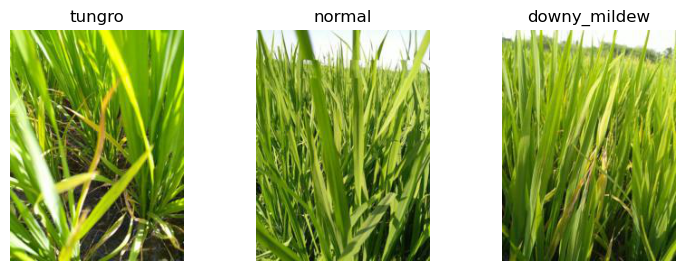

In [7]:
dls = ImageDataLoaders.from_folder(trn_path, 
                                   valid_pct=0.2, seed=42,
                                   item_tfms=Resize((256,192)))
dls.show_batch(max_n=3)

In [8]:
# Our train function
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [9]:
# So now it takes 33s per epoch with a 12.64% error (almost the same as previously)
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.935910,1.533450,0.479577,01:11


epoch,train_loss,valid_loss,error_rate,time
0,1.287928,1.030946,0.346468,00:32
1,1.016647,0.718874,0.234503,00:33
2,0.715255,0.493969,0.152331,00:33
3,0.530480,0.416236,0.135031,00:33
4,0.441251,0.395308,0.126382,00:33


## A ConvNeXt model

In [10]:
# Changing into a slightly slower but more accurate model.
# See models analysis here https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning
arch = 'convnext_small_in22k'

In [11]:
# Retrain using squish this time
# Here each epoch took 42s, but we doubled the accuracy (error 4.57%)
# and with the resizing at start, we train faster than the previous file.
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

c:\Users\eltar\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

c:\Users\eltar\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\eltar\.cache\huggingface\hub\models--timm--convnext_small.fb_in22k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


epoch,train_loss,valid_loss,error_rate,time
0,1.303372,0.848560,0.265257,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.656444,0.408221,0.129745,00:42
1,0.528957,0.382680,0.113888,00:43
2,0.327245,0.254123,0.086497,00:43
3,0.182673,0.184182,0.051898,00:42
4,0.128215,0.157903,0.045651,00:40


c:\Users\eltar\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## Preprocessing experiments

In [12]:
# Try the same but with crop (the default) instead of squish
# This time we got a slightly worse result (error 5.28%)
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

c:\Users\eltar\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.279709,0.990072,0.266218,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.733607,0.465843,0.148967,00:41
1,0.556346,0.395189,0.123018,00:42
2,0.372389,0.253137,0.084094,00:41
3,0.239365,0.180254,0.064392,00:42
4,0.165597,0.168069,0.052859,00:41


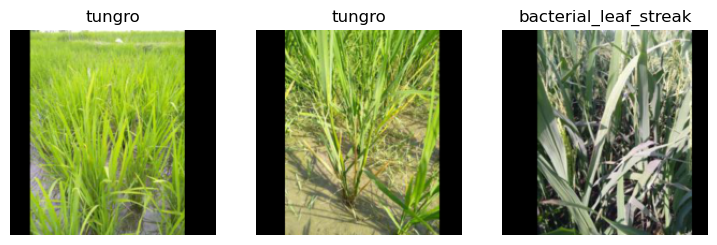

In [13]:
# Try with padding instead of cropping
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [14]:
# 4.9% error but it should be 4.5%
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

c:\Users\eltar\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.316030,0.816109,0.265738,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.647487,0.463055,0.150889,00:40
1,0.515563,0.421284,0.125420,00:39
2,0.324626,0.253281,0.083614,00:39
3,0.201761,0.160497,0.054301,00:39
4,0.129849,0.148492,0.049015,00:39


c:\Users\eltar\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


## Test time augmentation

In [15]:
# Try to predict our validation set
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [16]:
# Indeed the error is 4.9%
error_rate(preds, targs)

TensorBase(0.0490)

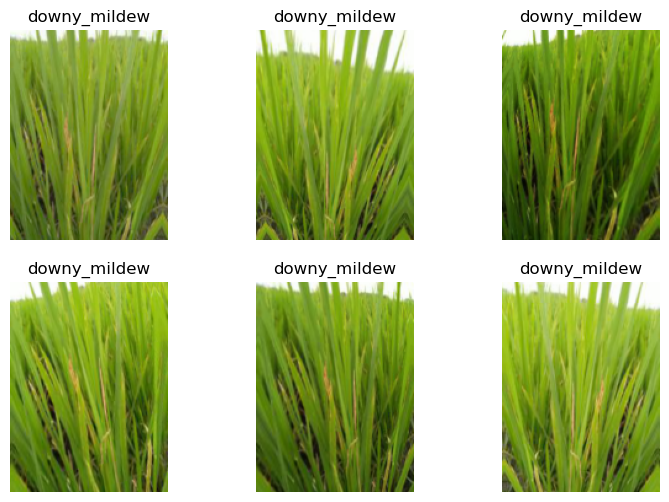

In [17]:
# We will use test time augmentation by changing the color, distort and rotate the images
learn.dls.train.show_batch(max_n=6, unique=True)

In [18]:
# We will use this technique to use in a sense a bag of tricks method
# and we will take the average error
tta_preds,_ = learn.tta(dl=valid)

In [19]:
# Indeed, the best error up to now, 4.47%
error_rate(tta_preds, targs)

TensorBase(0.0447)

## Scaling up

In [20]:
# We will repeat with the original images
trn_path = path/'data/train_images'

In [21]:
# We get 2.21% error
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

c:\Users\eltar\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.041411,0.606437,0.174435,01:40


epoch,train_loss,valid_loss,error_rate,time
0,0.512181,0.287035,0.090822,01:52
1,0.401194,0.278967,0.086497,01:52
2,0.347048,0.267551,0.086497,01:52
3,0.294755,0.196257,0.057184,01:50
4,0.235727,0.277231,0.067275,01:52
5,0.163670,0.180677,0.054301,01:52
6,0.126149,0.142457,0.040846,01:53
7,0.098993,0.151888,0.043729,01:48
8,0.072746,0.111602,0.026430,01:48
9,0.049399,0.099712,0.027871,01:49


c:\Users\eltar\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [22]:
# Predict with test time augmentation on the validation set
# We get 2.16% error
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0216)

## Submission

In [23]:
# Get the test set and run the model
tst_files = get_image_files(path/'data/test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [24]:
# Predict with test time augmentation
preds,_ = learn.tta(dl=tst_dl)

In [35]:
path = Path.cwd()

In [36]:
# Save the fine tuned model (serialized pickle format)
learn.export(path/'models'/'model_02.pkl')

In [37]:
# Create the submission CSV
idxs = preds.argmax(dim=1)

In [38]:
# A very CPU efficient and fast way to do indexing
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [40]:
# Save the file
ss = pd.read_csv(path/'data/sample_submission.csv')
ss['label'] = results
ss.to_csv('subm_02.csv', index=False)
# This submission was at the top 25% of the contest.